###  Car Price Modeling Project

* Part 1 - Predict price with car metadata

* Part 2 - Predict price with metadata + image

* Details:  Get metadata from craigslist API.  Get additional relevant features, like gas price.  
  Clean data.  Put clean data in SQLite database.

### `Research Notes`

In [1]:
#KEY FEATURES
#price label, brand, model, age, horsepower/engine_type, mileage. time passage from ad post?

#SECONDARY FEATURES
#make, fuel type, mpg, exterior color, door number, transmission type,
#dimensions, safety, air condition, interior, navigation y/n, engine type
#cubic capacity, number of ad views, power steering, rim type
#registered city, number of doors, 4WD, damaged, leather, alarm,
#A/C, parking sensors, xenon lights, remote unlock, electric mirrors,
#seat heat, moon roof, cruise control, abs, traction control

#OTHER FEATURES
#estimated car life, price rank as category (cheap, moderate, expensive)

#Non-craigslist features
# gas price,

#Sparse features to ignore?: damaged, city

In [2]:
#FEATURE ENHANCEMENT:
#Train with stratified sample of make
#Encode Thumbs Up/Down fields: [ON, OFF, NotAvailable] -> [1, -1, 0]
#Poly features for regression.  Ex. Mileage and year
#Differencing features and explicit features for orest.

In [3]:
# Candidate models
# Regression, KNN, SVM, random forest, naive bayes, neural networks
# Neural network should be best, followed by RF and SVM.

In [4]:
# Frame as Price as Regression vs Classification Problem
# Classification: bin continuous features using cluster analysis?

###  Imports

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re

#pd.set_option('max_colwidth', 2000)
pd.options.display.max_rows = 500

#Models for prediction
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [6]:
%pwd

'C:\\Users\\Justin\\DATA_SCIENCE\\scrape_craigslist'

In [7]:
vehicle=pd.read_json('vehicle.json')

In [8]:
def one_hot_encode(train_df, test_df, cat_cols):
    '''
    One-Hot Encode train category columns.  Apply identical encoding to test.
    Unknown category for test handled by returning all zeroes column.  Function
    keeps original dataframe indices intact.
    '''
    from sklearn.preprocessing import OneHotEncoder
    ohe = OneHotEncoder(sparse=False, drop=None, handle_unknown='ignore')  #drop None or 'first'
    #fit_transform train cat_cols.
    ohe_train_df=pd.DataFrame(ohe.fit_transform(train_df[cat_cols]))
    ohe_train_df.index=train_df.index
    ohe_train_df.columns=ohe.get_feature_names(cat_cols)
    #Transform test.  Categories exclusive to train get zeros in test.  Categories exclusive to test are omitted.
    ohe_test_df=pd.DataFrame(ohe.transform(test_df[cat_cols]))
    ohe_test_df.index=test_df.index
    ohe_test_df.columns=ohe.get_feature_names(cat_cols)
    return ohe_train_df, ohe_test_df

In [9]:
from sklearn.base import clone
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error

def train_and_valid(what_model, num_folds, X, y):
    fold_rsme=[]
    kf=KFold(n_splits=num_folds, shuffle=True, random_state=30)    
        
    for train_index, valid_index in kf.split(X):                         #split train data excluding holdout
        #Clone is copy of model not yet fit on any data.  Initial conditions impact certain model results, like SGD.
        clone_model = clone(what_model)                                  
        trn_X, valid_X = X.iloc[train_index, :], X.iloc[valid_index, :]  #df has columns
        trn_y, valid_y = y.iloc[train_index], y.iloc[valid_index]        #series no columns

        clone_model.fit(trn_X, trn_y)
        valid_pred=clone_model.predict(valid_X)
        fold_rsme.append(round(np.sqrt(mean_squared_error(valid_y, valid_pred)), 3))
    return fold_rsme, clone_model

In [10]:
#Add feature columns and view dataframe
print('vehicle length:', len(vehicle))
print('vehicle type:', type(vehicle))
vehicle.insert(2,'Year',np.nan)
vehicle.insert(3,'Year_in_Title',np.nan)
vehicle.insert(4,'Make',np.nan)
vehicle.insert(5,'Model',np.nan)
vehicle.insert(6,'Trim',np.nan)
vehicle.insert(8,'LN_Price',np.nan)
vehicle.head(3)

vehicle length: 374
vehicle type: <class 'pandas.core.frame.DataFrame'>


,URL_Vehicle,Title,Year,Year_in_Title,Make,Model,Trim,Price,LN_Price,SubLoc,AttribDictionary,ImageDictionary
0,https://houston.craigslist.org/cto/d/houston-2...,2010 Honda Accord Coupe EX-L/1 Owner/Clean Title,NaN,NaN,NaN,NaN,NaN,$6750,NaN,None,{'0': '<span><b>2010 honda accord ex-l coupe</...,{'0': 'https://images.craigslist.org/00X0X_ibG...
1,https://houston.craigslist.org/cto/d/spring-19...,1999 Honda Prelude,NaN,NaN,NaN,NaN,NaN,$4500,NaN,(Spring),{'0': '<span><b>1999 Honda Prelude</b></span>'...,{'0': 'https://images.craigslist.org/00E0E_dZp...
2,https://houston.craigslist.org/cto/d/hempstead...,1998 Honda Accord OBO,NaN,NaN,NaN,NaN,NaN,$2200,NaN,(Hempstead),"{'0': '<span><b>1998 Honda Accord</b></span>',...",{'0': 'https://images.craigslist.org/00Q0Q_a84...


In [11]:
vehicle.loc[0:3, 'AttribDictionary']

0    {'0': '<span><b>2010 honda accord ex-l coupe</...
1    {'0': '<span><b>1999 Honda Prelude</b></span>'...
2    {'0': '<span><b>1998 Honda Accord</b></span>',...
3    {'0': '<span><b>2017 HONDA CIVIC EX</b></span>...
Name: AttribDictionary, dtype: object

In [12]:
#Build Year column from AttribDictionary and verify numeric format. 
yrList=[]
for idx in vehicle.index:
    m = re.search('(\d+)', vehicle.loc[idx, 'AttribDictionary']['0'])  #re.search(pattern, string) gets first match
    yrList.append(m.group(1))  #group(1) returns first parenthesized subgroup
vehicle['Year'] = yrList    
vehicle['Year'] = vehicle['Year'].astype('float').astype('Int64')

assert vehicle['Year'].dtypes == 'Int64',  "Year must be a nullable integer."
assert len(vehicle[vehicle['Year'].isna()]) == 0, "Year cannot have NAs."

In [13]:
#Extract RawMake col from AttribDictionary.
rawMakeList=[]

for idx in vehicle.index:
    m = re.search('<b>(.+)</b>', vehicle.loc[idx, 'AttribDictionary']['0']) #re.search(pattern, string) gets first match
    if m is not None:
        rawMakeList.append(m.group(1).lower())
    else:
        print('Missing Make/Model index:', idx)
        rawMakeList.append('None')
                 
vehicle['RawMake'] = rawMakeList

In [14]:
#Extract Make col from RawMake col.

#Regex patter
patt='\d*\s{0,2}\d+\s{1,2}(\w+)\s{0,2}(\w*-?[a-z]?)\s{0,2}(\w*-?[a-z]?)'

#Regex patter in verbose (re.X) format.
pattVerbose=re.compile(r'''\d*\s{0,2}     # 0 or more digits and 0-2 spaces
                           \d+\s{1,2}     # 1 or more digits and 1-2 spaces
                           (\w+)          # 1 or more words
                           \s{0,2}        # 0-2 whitespaces
                           (\w*-?[a-z]?)  # 0 or more words, 0 or 1 "-", 0 or 1 letter a-z
                           \s{0,2}        # 0-2 whitespaces
                           (\w*-?[a-z]?)  # 0 or more words, 0 or 1 "-", 0 or 1 letter a-z
                        ''', re.X)

makeList=[]
for idx in vehicle.index:
    m = re.search(pattVerbose, vehicle.loc[idx, 'RawMake']) #re.search(pattern, string) gets first match
    if m is not None:
        makeList.append([m.group(1).lower(), m.group(2).lower(), m.group(3).lower()])
    else:
        print('Missing Make/Model index:', idx)
        makeList.append('None')
                 
vehicle['Make']=[item[0] for item in makeList]
vehicle['Model']=[item[1] for item in makeList]
vehicle['Trim']=[item[2] for item in makeList]

In [15]:
#Price - remove any $ and cast as float.
vehicle['Price'] = vehicle['Price'].str.replace('$','')
vehicle['Price'] = vehicle['Price'].astype('float')
assert len(vehicle[vehicle['Price'].isna()]) == 0, "Price cannot have NAs."

In [16]:
from scipy import stats
from scipy.stats import norm

def normalize_feature(df, bad_feature):
    
    #Make histogram & normal probability plot
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(df[bad_feature], color='r', fit=stats.norm, ax=ax1)
    ax1.set_title(f'{bad_feature} Histogram - Not Normal Distribution')
    res=stats.probplot(df[bad_feature], dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')

    #Normalize with log (x+1).  Log of skewed feature: log e(feature+1)=normFeat
    #Exponential equation to undo normpr: e^normFeat-1=feature
    log_feat=np.log(df[bad_feature]+1)
        
    #Plots after normalization
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,3),constrained_layout=True)
    sns.distplot(log_feat, color='g', fit=norm, ax=ax1)
    ax1.set_title(bad_feature+' Histogram - Normal Distribution')
    res=stats.probplot(log_feat, dist='norm', plot=ax2)
    ax2.set_title('Fit to Normal Distribution')
    return log_feat

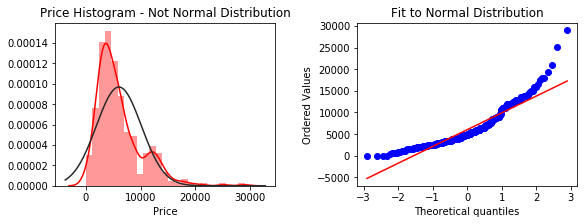

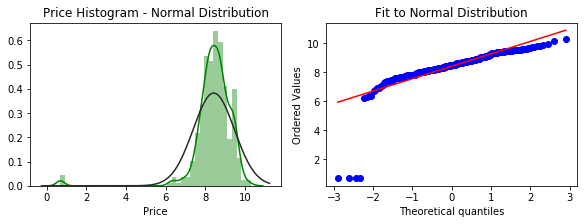

In [17]:
vehicle['LN_Price'] = normalize_feature(df=vehicle, bad_feature='Price')

In [18]:
vehicle.head()

,URL_Vehicle,Title,Year,Year_in_Title,Make,Model,Trim,Price,LN_Price,SubLoc,AttribDictionary,ImageDictionary,RawMake
0,https://houston.craigslist.org/cto/d/houston-2...,2010 Honda Accord Coupe EX-L/1 Owner/Clean Title,2010,NaN,honda,accord,ex-l,6750.0,8.817446,None,{'0': '<span><b>2010 honda accord ex-l coupe</...,{'0': 'https://images.craigslist.org/00X0X_ibG...,2010 honda accord ex-l coupe
1,https://houston.craigslist.org/cto/d/spring-19...,1999 Honda Prelude,1999,NaN,honda,prelude,,4500.0,8.412055,(Spring),{'0': '<span><b>1999 Honda Prelude</b></span>'...,{'0': 'https://images.craigslist.org/00E0E_dZp...,1999 honda prelude
2,https://houston.craigslist.org/cto/d/hempstead...,1998 Honda Accord OBO,1998,NaN,honda,accord,,2200.0,7.696667,(Hempstead),"{'0': '<span><b>1998 Honda Accord</b></span>',...",{'0': 'https://images.craigslist.org/00Q0Q_a84...,1998 honda accord
3,https://houston.craigslist.org/cto/d/south-hou...,2017 HONDA CIVIC EX,2017,NaN,honda,civic,ex,12900.0,9.465060,None,{'0': '<span><b>2017 HONDA CIVIC EX</b></span>...,{'0': 'https://images.craigslist.org/00j0j_6Dx...,2017 honda civic ex
4,https://houston.craigslist.org/cto/d/el-paso-2...,2006 HONDA ODYSSEY ORIGINAL OWNER TRACTION CON...,2006,NaN,honda,odyssey,,1500.0,7.313887,None,{'0': '<span><b>2006 Honda Odyssey</b></span>'...,{'0': 'https://images.craigslist.org/00z0z_8jK...,2006 honda odyssey


In [19]:
vehicle['Model'].value_counts()

accord       124
civic         97
odyssey       47
pilot         31
cr-v          26
crv           17
s2000          7
fit            4
element        4
prelude        3
insight        3
               3
odessey        2
ridgeline      2
oddysey        1
cr             1
acc            1
toyota         1
Name: Model, dtype: int64

In [20]:
#Fix Model spelling

model_dict={
            'Model': {np.nan : 'None', 
                      '' : 'None',
                      'cr' : 'cr-v',
                      'crv' : 'cr-v', 
                      'odessey' : 'odyssey', 
                      'oddysey' : 'odyssey'}
            }

vehicle.replace(model_dict, inplace=True)
vehicle['Model'].value_counts()

accord       124
civic         97
odyssey       50
cr-v          44
pilot         31
s2000          7
element        4
fit            4
None           3
insight        3
prelude        3
ridgeline      2
toyota         1
acc            1
Name: Model, dtype: int64

In [21]:
#Exclude rare models
rare_filt = (vehicle['Model'] =='s2000') | (vehicle['Model'] =='element') | (vehicle['Model'] =='fit') |\
(vehicle['Model'] =='') | (vehicle['Model'] =='prelude') | (vehicle['Model'] =='insight') |\
(vehicle['Model'] =='ridgeline') | (vehicle['Model'] =='odessey') | (vehicle['Model'] =='cr') |\
(vehicle['Model'] =='toyota') | (vehicle['Model'] =='oddysey') | (vehicle['Model'] =='acc') |\
(vehicle['Model'] =='pilot') | (vehicle['Model'] =='None')

vehicles = vehicle[~rare_filt]
vehicles['Model'].value_counts()

accord     124
civic       97
odyssey     50
cr-v        44
Name: Model, dtype: int64

In [22]:
#Build train and test, stratified by Model.
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=22)
for train_index, test_index in sss.split(vehicles, vehicles['Model']):
    train = vehicles.iloc[train_index]
    test = vehicles.iloc[test_index]

In [23]:
#Drop some features
train = train.drop(['URL_Vehicle', 'Title', 'Year_in_Title', 'LN_Price', 'SubLoc', 'AttribDictionary', 'ImageDictionary', 'RawMake'],
           axis='columns', errors='ignore')

test = test.drop(['URL_Vehicle', 'Title', 'Year_in_Title', 'LN_Price', 'SubLoc', 'AttribDictionary', 'ImageDictionary', 'RawMake'],
           axis='columns', errors='ignore')
display('train:', train.head(2))
display('test:', test.head(2))

'train:'

,Year,Make,Model,Trim,Price
293,2009,honda,civic,ex,3950.0
118,2005,honda,civic,lx,3100.0


'test:'

,Year,Make,Model,Trim,Price
343,2002,honda,accord,,1000.0
132,2006,honda,civic,,4900.0


In [24]:
#One-Hot Encode train and test.
categ_cols= ['Year', 'Make', 'Model','Trim']
ohe_train_df, ohe_test_df = one_hot_encode(train_df=train, test_df=test, cat_cols=categ_cols)

In [25]:
#Drop original category columns.  Add OHE category columns.
train = train.drop(columns=categ_cols, axis='columns', errors='ignore')
test = test.drop(columns=categ_cols, axis='columns', errors='ignore')

train = pd.concat([train, ohe_train_df], axis='columns')
test = pd.concat([test, ohe_test_df], axis='columns')
display('train:', train.head(2))
display('test:', test.head(2))

'train:'

,Price,Year_1994,Year_1995,Year_1997,Year_1998,Year_1999,Year_2000,Year_2001,Year_2002,Year_2003,...,Trim_hb,Trim_hybrid,Trim_lx,Trim_lx-p,Trim_se,Trim_sedan,Trim_si,Trim_sport,Trim_touring,Trim_v
293,3950.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
118,3100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


'test:'

,Price,Year_1994,Year_1995,Year_1997,Year_1998,Year_1999,Year_2000,Year_2001,Year_2002,Year_2003,...,Trim_hb,Trim_hybrid,Trim_lx,Trim_lx-p,Trim_se,Trim_sedan,Trim_si,Trim_sport,Trim_touring,Trim_v
343,1000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132,4900.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#Create trainX, trainY, testX, and testY
trainX = train.copy()
trainY =trainX.pop('Price')
testX = test.copy()
testY = testX.pop('Price')

### 10 Noise Features at 0.995 pct zeros cutoff:  ###
### Noise Features: ['Year_1994', 'Year_1995', 'Year_1997', 'Make_honda', 'Trim_2012', 'Trim_97', 'Trim_lx-p', 'Trim_se', 'Trim_sedan', 'Trim_v']  ###

Count nonzero - 1 :


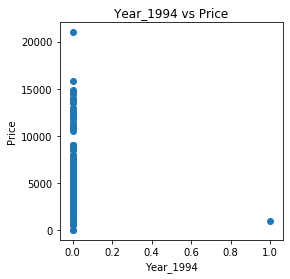

Count nonzero - 1 :


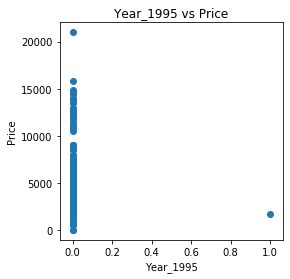

Count nonzero - 1 :


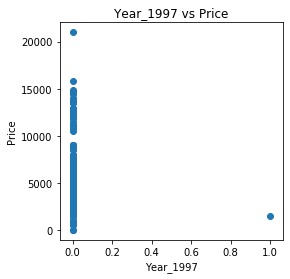

Count nonzero - 3 :


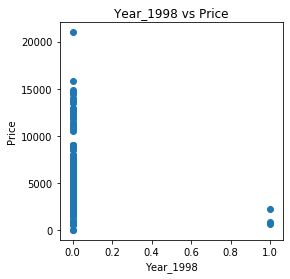

Count nonzero - 3 :


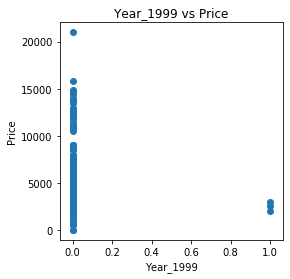

Count nonzero - 5 :


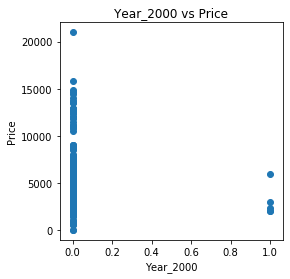

Count nonzero - 5 :


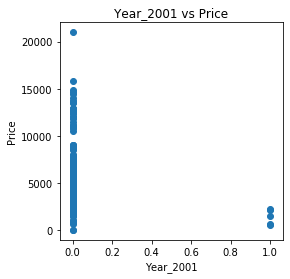

Count nonzero - 7 :


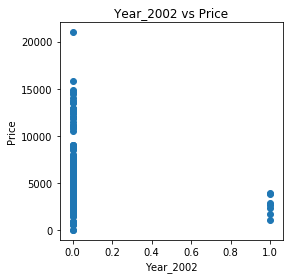

Count nonzero - 6 :


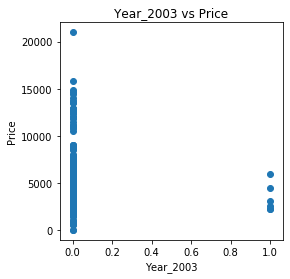

Count nonzero - 14 :


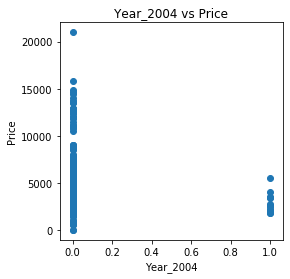

Count nonzero - 17 :


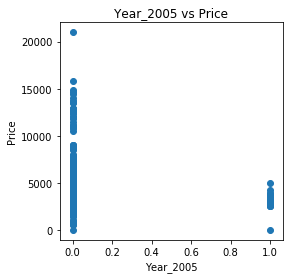

Count nonzero - 15 :


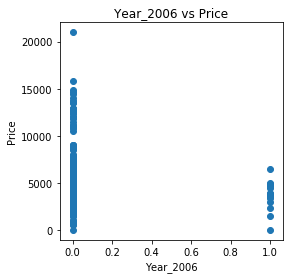

Count nonzero - 26 :


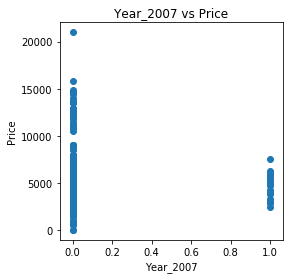

Count nonzero - 22 :


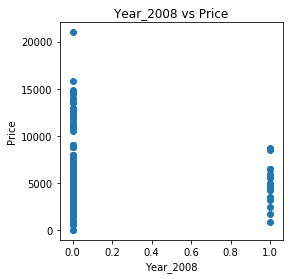

Count nonzero - 25 :


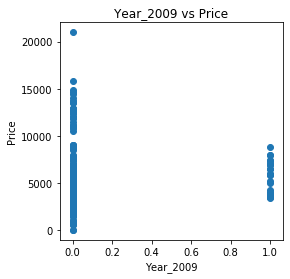

Count nonzero - 18 :


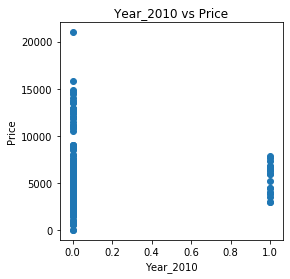

Count nonzero - 5 :


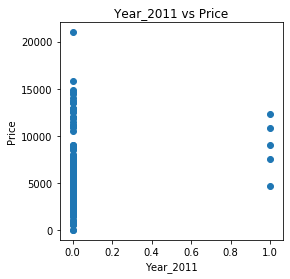

Count nonzero - 15 :


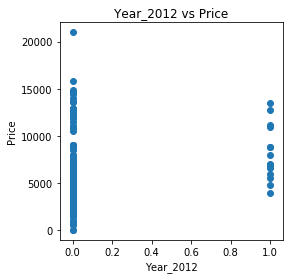

Count nonzero - 6 :


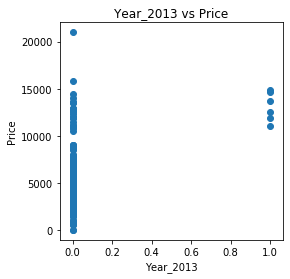

Count nonzero - 6 :


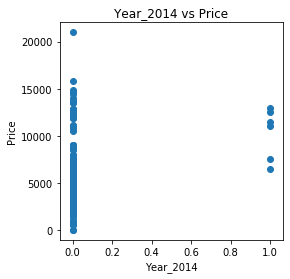

Count nonzero - 4 :


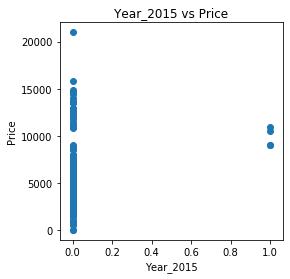

Count nonzero - 3 :


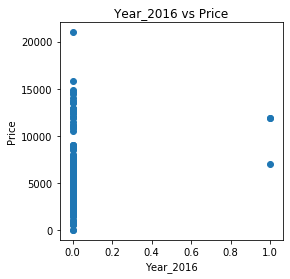

Count nonzero - 5 :


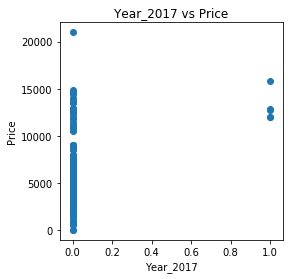

Count nonzero - 5 :


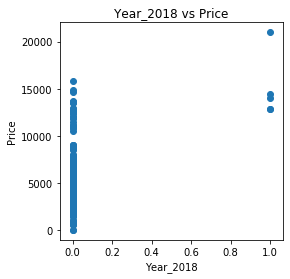

Count nonzero - 2 :


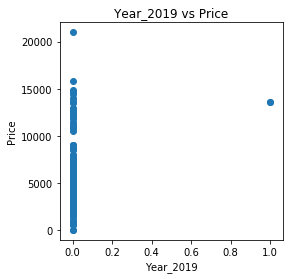

Count nonzero - 0 :


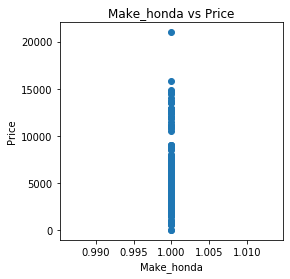

Count nonzero - 86 :


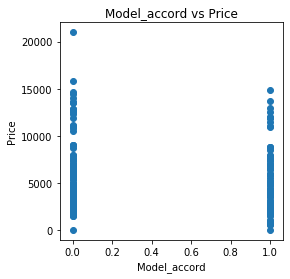

Count nonzero - 68 :


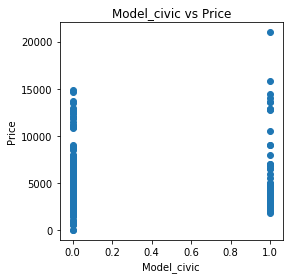

Count nonzero - 31 :


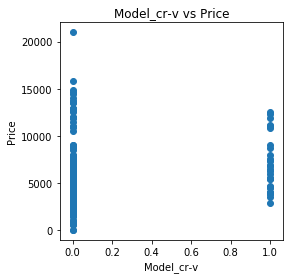

Count nonzero - 35 :


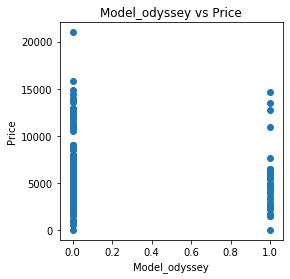

Count nonzero - 89 :


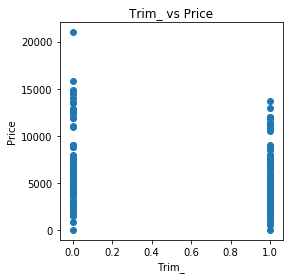

Count nonzero - 1 :


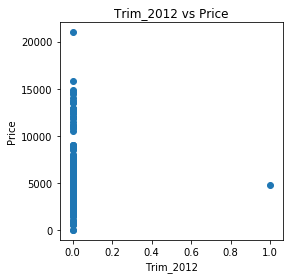

Count nonzero - 1 :


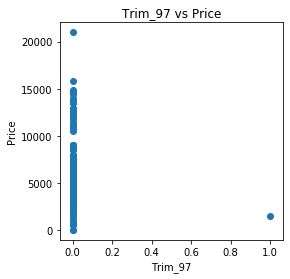

Count nonzero - 5 :


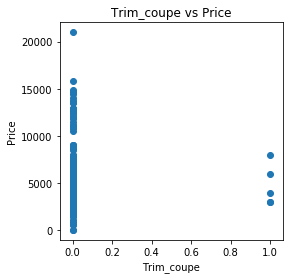

Count nonzero - 26 :


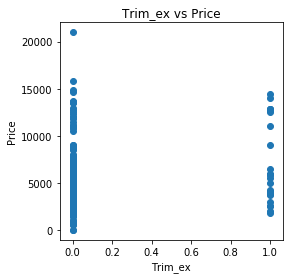

Count nonzero - 21 :


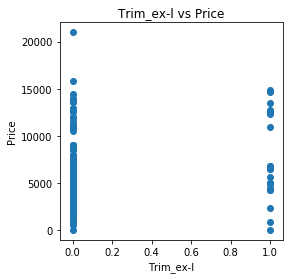

Count nonzero - 3 :


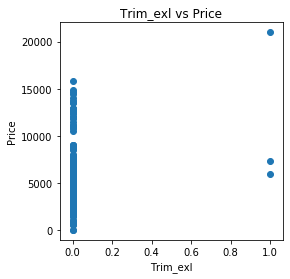

Count nonzero - 2 :


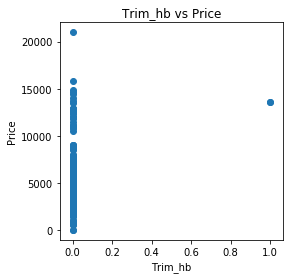

Count nonzero - 2 :


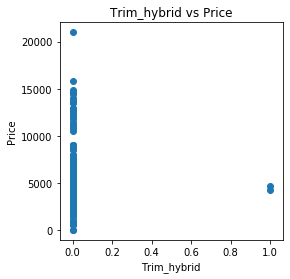

Count nonzero - 17 :


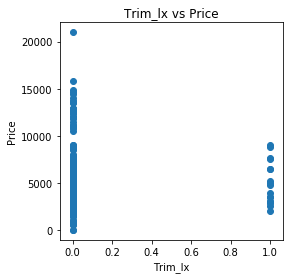

Count nonzero - 1 :


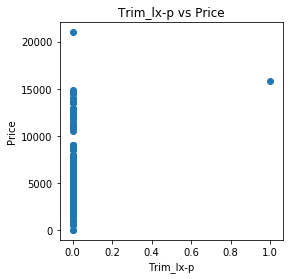

Count nonzero - 1 :


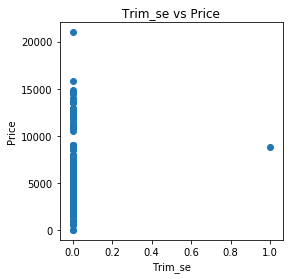

Count nonzero - 1 :


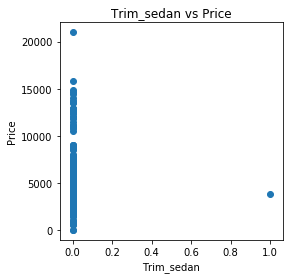

Count nonzero - 2 :


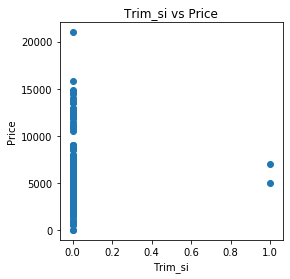

Count nonzero - 2 :


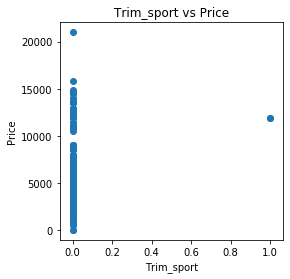

Count nonzero - 3 :


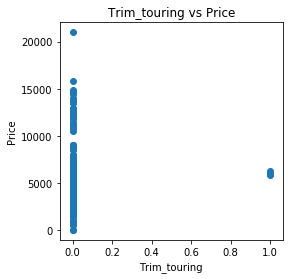

Count nonzero - 1 :


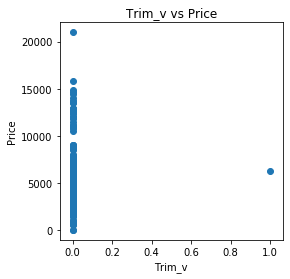

In [27]:
#Review noise features - where one category is nearly all observations.
noise_feat = []
pct_zeros = .995
for i in trainX.columns:
    counts = trainX[i].value_counts()
    zeros = counts.iloc[0]  #top frequency category    
    if zeros / len(trainX) > pct_zeros:
        noise_feat.append(i)

print(f'### {len(noise_feat)} Noise Features at {pct_zeros} pct zeros cutoff:  ###')
print(f'### Noise Features: {noise_feat}  ###\n')

for c in trainX.columns:
    counts = trainX[c].value_counts()
    zeros = counts.iloc[0]  #top frequency category
    print('Count nonzero -', (len(trainX[c]) - zeros),':')
    plt.figure(figsize=[4,4])
    plt.scatter(trainX[c], trainY)
    plt.title(f'{c} vs Price'); plt.xlabel(f'{c}'); plt.ylabel('Price');
    plt.show()

In [28]:
# #Drop noise features.  Will help non-regularized models by reducing dimensionality.
# trainX = trainX.drop(columns=noise_feat, axis='columns', errors='ignore')
# testX = testX.drop(columns=noise_feat, axis='columns', errors='ignore')

## `Tune Models with Cross Validation`

In [29]:
#Train and Score LR CV
lr=LinearRegression(fit_intercept=False)
fold_rsme, linMod = train_and_valid(what_model=lr, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## LR R^2:', round(linMod.score(trainX, trainY),3))

Fold RSME: [1468.476, 2136.362, 2109.041, 237092495715058.88, 656177425629742.2, 812036160122543.2, 1426.9, 32215776419329.742, 1909.305, 1890.25]
## Avg RMSE: 173752185789761.44 +- 290744565961281.25
## LR R^2: 0.852


In [30]:
#Train and Score Ridge CV
ridge=Ridge(alpha=0.1, solver='cholesky')
fold_rsme, ridgeMod = train_and_valid(what_model=ridge, num_folds=10, X=trainX, y=trainY)
print('Fold RSME:', fold_rsme)
print('## Avg RMSE:', round(np.mean(fold_rsme),4),'+-', round(np.std(fold_rsme),4))
print('## ridge R^2:', round(ridgeMod.score(trainX, trainY),3))

Fold RSME: [1436.023, 2231.424, 2146.179, 2016.045, 1873.691, 1967.705, 1429.103, 1311.23, 1918.609, 1900.753]
## Avg RMSE: 1823.0762 +- 302.3295
## ridge R^2: 0.851


## `Predict`

In [31]:
linregr=LinearRegression(fit_intercept=False)  #no scaling required for closed-form solution
linregr.fit(trainX, trainY)
y_pred_linregr=linregr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_linregr)), 4)
print('test RMSE:', RMSE)
print('test R^2 test:', round(linregr.score(testX, testY),4))

test RMSE: 2516.5127
test R^2 test: 0.6094


In [32]:
rr=Ridge(alpha=.1, solver='cholesky')  #no scaling required for closed-form solution
rr.fit(trainX, trainY)
y_pred_rr=rr.predict(testX)
RMSE = rmse=round(np.sqrt(mean_squared_error(testY, y_pred_rr)), 4)
print('test RMSE:', RMSE)
print('test R^2:', round(rr.score(testX, testY),4))

test RMSE: 2483.5821
test R^2: 0.6196


### *Need more data to improve predictions!*

* Pick for sale by all (owner or dealer) rather than just owner
* Combine Houston with College Station and Galveston?
* Pick more common manufacturer Ex. Ford?

In [38]:
#Existing data is Honda for sale by Owner
print('train (rows,cols):', trainX.shape)
print('test (rows,cols):', testX.shape)

train (rows,cols): (220, 47)
test (rows,cols): (95, 47)


In [34]:
#*********************************UNUSED CODE**************************************

# #Extract Year_in_Title from vehicle Title and save off column - pandas.Series.str.extract

# patt='(\d+)'
# vehicle['Year_in_Title'] = vehicle['Title'].str.extract(patt).replace(np.nan, 'None')

# def fix_2digit(row):
#     if len(row) == 4 or row == 'None':
#         return row
#     elif row in [str(dig).zfill(2) for dig in range(0,21)]:    #Assume 00 - 20 is 2000s
#         return '20' + row
#     elif row in [str(dig).zfill(2) for dig in range(21,100)]:  #Assume 21 - 99 is 1900s
#         return '19' + row
#     else:
#         return 'None'
    
# vehicle['Year_in_Title'] = vehicle['Year_in_Title'].apply(fix_2digit)
# vehicle['Year_in_Title'] = vehicle['Year_in_Title'].replace('None',np.nan).astype('float').astype('Int64')
# vehicle['Year_in_Title'].value_counts(dropna=False)

#re.search('<b>(\d*\s{0,2})(\d+\s{1,2}\w+\s{1,2}\w+\s{0,2}\w*)</b>', vehicle.loc[55, 'AttribDictionary']['0']).group(0)